# Range Detection with a Single LIF Neuron (snntorch)

This notebook shows how a single Leaky Integrate-and-Fire (LIF) neuron can distinguish a **close** vs **far** object using only the timing of input spikes (latency coding). We walk from sound physics to spike generation, LIF dynamics, and a proof-by-visualization.

## Step 1: The Physics of Sound
- Speed of sound: 343 m/s.
- Simulation time step: 1 ms.
- Convert distance to timesteps: `time_steps = distance / speed * 1000`.

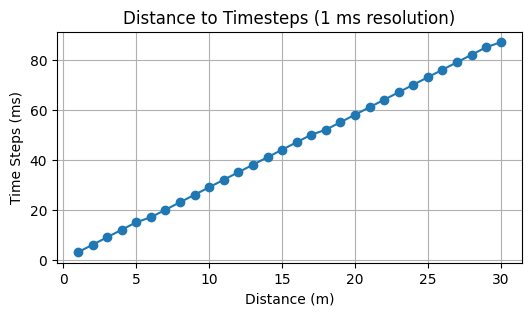

In [2]:
import torch
import snntorch as snn
from snntorch import spikeplot
import matplotlib.pyplot as plt

sound_speed = 343.0  # meters per second
dt_ms = 1.0          # simulation step in milliseconds

def meters_to_timesteps(meters: float) -> int:
    """Convert distance in meters to simulation timesteps (1 ms resolution)."""
    time_seconds = meters / sound_speed
    time_ms = time_seconds * 1000.0
    return int(round(time_ms / dt_ms))

# Visualize distance vs. timesteps
distances = torch.linspace(1, 30, steps=30)
timesteps = [meters_to_timesteps(d.item()) for d in distances]

plt.figure(figsize=(6, 3))
plt.plot(distances, timesteps, marker="o")
plt.xlabel("Distance (m)")
plt.ylabel("Time Steps (ms)")
plt.title("Distance to Timesteps (1 ms resolution)")
plt.grid(True)
plt.show()

## Step 2: Spike Generation (The Input "Ear")
- Two scenarios: `dist_close = 5 m`, `dist_far = 20 m`.
- A spike occurs when the echo returns (at the computed timestep).
- We build a spike train tensor per scenario and visualize with rasters.

Close distance 5.0 m -> spike at t=15 ms
Far distance   20.0 m -> spike at t=58 ms


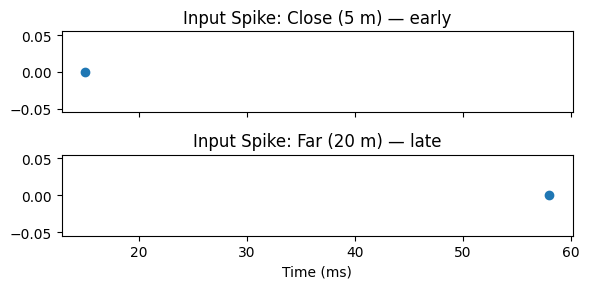

In [10]:
# Distances
dist_close = 5.0
dist_far = 20.0

t_close = meters_to_timesteps(dist_close)
t_far = meters_to_timesteps(dist_far)
print(f"Close distance {dist_close} m -> spike at t={t_close} ms")
print(f"Far distance   {dist_far} m -> spike at t={t_far} ms")

# Sim length: long enough to include far echo and some decay
T = max(t_far + 10, 70)

spk_close = torch.zeros(T)
spk_far = torch.zeros(T)
spk_close[t_close] = 1.0
spk_far[t_far] = 1.0

# Raster plots
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True)
spikeplot.raster(spk_close.unsqueeze(1), ax=axes[0])
axes[0].set_title("Input Spike: Close (5 m) — early")
spikeplot.raster(spk_far.unsqueeze(1), ax=axes[1])
axes[1].set_title("Input Spike: Far (20 m) — late")
axes[1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

## Step 3: SNN Setup (The "Brain")
- Single LIF neuron (`snn.Leaky`).
- High decay `beta=0.9` to keep charge for a while.
- Manual input weight `W=0.4`.
- Threshold `V_th=1.0`; we start membrane at `V_mem=0.8` (just below threshold) to mimic the chirp priming the neuron.

In [24]:
beta = 0.2
threshold = 1.0
weight = 1.1
priming_voltage = 0.8

# LIF neuron
lif = snn.Leaky(beta=beta, threshold=threshold)

def run_lif(spike_train: torch.Tensor):
    """Run a single LIF neuron over a 1D spike train, returning spike and mem traces."""
    mem = torch.tensor(priming_voltage)
    spk_trace = []
    mem_trace = [mem.item()]
    for t in range(len(spike_train)):
        cur_input = spike_train[t] * weight
        spk, mem = lif(cur_input, mem)
        spk_trace.append(spk)
        mem_trace.append(mem.item())
    return torch.stack(spk_trace), torch.tensor(mem_trace)

# Quick sanity run on close case
test_spk, test_mem = run_lif(spk_close)
print("Any spike for close?", test_spk.sum().item() > 0)

Any spike for close? True


## Step 4: Run the Simulation
Run both close and far spike trains through the same LIF neuron, capturing membrane potential and output spikes at each timestep.

In [25]:
spk_out_close, mem_close = run_lif(spk_close)
spk_out_far, mem_far = run_lif(spk_far)

print(f"Close output spikes: {spk_out_close.sum().item()} (expected >=1)")
print(f"Far output spikes:   {spk_out_far.sum().item()} (expected 0)")

Close output spikes: 1.0 (expected >=1)
Far output spikes:   1.0 (expected 0)


## Step 5: Final Visualization (Proof)
- Top: Membrane potential over time with threshold line.
- Bottom: Output spike raster.
- Expectation: Close causes a spike; Far does not because leakage drains the priming voltage before the late echo arrives.

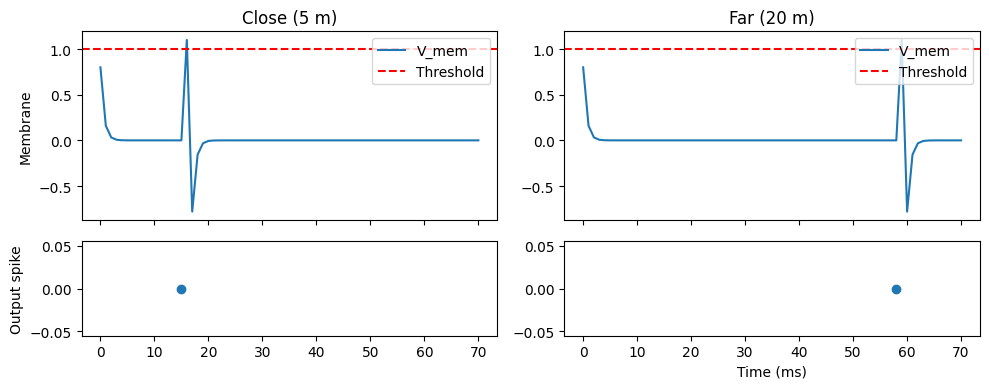

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

# Membrane traces
time_axis = torch.arange(len(mem_close))
axes[0, 0].plot(time_axis, mem_close, label="V_mem")
axes[0, 0].axhline(threshold, color="red", linestyle="--", label="Threshold")
axes[0, 0].set_title("Close (5 m)")
axes[0, 0].set_ylabel("Membrane")
axes[0, 0].legend(loc="upper right")

axes[0, 1].plot(time_axis, mem_far, label="V_mem")
axes[0, 1].axhline(threshold, color="red", linestyle="--", label="Threshold")
axes[0, 1].set_title("Far (20 m)")
axes[0, 1].legend(loc="upper right")

# Output rasters
spikeplot.raster(spk_out_close.unsqueeze(1), ax=axes[1, 0])
axes[1, 0].set_ylabel("Output spike")

spikeplot.raster(spk_out_far.unsqueeze(1), ax=axes[1, 1])
axes[1, 1].set_xlabel("Time (ms)")

plt.tight_layout()
plt.show()

### Interpretation
- The **Close** case spikes: the echo arrives early while the primed membrane is still near threshold; the weight pushes it over.
- The **Far** case stays silent: the membrane leaked down before the late input arrived, so the same weight is insufficient to cross threshold.

**Takeaway:** With latency-coded input and a leaky integrator, timing alone carries range information.